<h2>Brief description of the problem and data</h2>

<p>The challange problem for this assignment is: given a set of tweets from the social media platform Twitter, use Natural Language Processing (NLP) to determine which tweets reference an emergency (car crash, house fire, etc.) or natural disaster (earthquake, forest fire, torando, etc.) and which do not. Use any Kaggle tutorials, discussion boards, and code examples posted for this challenge but be sure to explain in your own words your understanding of the code used and reasons for using it.</p>
<p>The data in question, as mentioned above, are tweets. Tweets are composed of strings of text that contain characters, symbols and numbers. Each tweet can have at most 160 characters. Below is a counting of the total tweets in both data sets.</p>

In [453]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
import keras_nlp

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt

import keras_tuner
from keras_tuner.tuners import RandomSearch

from sklearn import feature_extraction, linear_model, model_selection, preprocessing

import nltk
from nltk.corpus import stopwords

import json
import os
import sys
import string
import re

os.environ["KERAS_BACKEND"] = "tensorflow"

print("TensorFlow version:", tf.__version__)
print(f"Keras Version: {keras.__version__}")
print("KerasNLP version:", keras_nlp.__version__)
print()
print(f"Python {sys.version}")
gpu_list = tf.config.list_physical_devices('GPU')
gpu = len(gpu_list)>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(gpu_list)



TensorFlow version: 2.10.0
Keras Version: 2.10.0
KerasNLP version: 0.6.1

Python 3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]
GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
path_add = 'C:/Users/kgrit/OneDrive/Documents/UC boulder Data science masters/Intro to deep learning/week 4/assignment rough draft/'
df_train = pd.read_csv(path_add + "data/train.csv")
df_test = pd.read_csv(path_add + "data/test.csv")

display(df_train.head(n=5))
print('Training Set Shape = {}'.format(df_train.shape))
display(df_test.head(n=5))
print('Test Set Shape = {}'.format(df_test.shape))
print('\nTotal number of tweets in all data sets = {}'.format(df_train.shape[0] + df_test.shape[0]))

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Training Set Shape = (7613, 5)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Test Set Shape = (3263, 4)

Total number of tweets in all data sets = 10876


<p>The training data set has 7,613 tweets while the testing data set has 3,263 tweets, for a grand total of 10,876 tweets in both data sets.</p>

<h2>Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data</h2> 

<h3>EDA - statistics and visualizations</h3>

<p>First lets take a quick look at the length of the tweets in question, and some statistics of those lengths.</p>

In [64]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
df_train_len_desc = df_train["length"].describe()
print(df_train_len_desc)
print()

print("Test Length Stat")
df_test_len_desc = df_test["length"].describe()
print(df_test_len_desc)
#print(df_test_len_desc['25%'])

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


<p>Above you can see that in the training data set, the average length of a tweet is about 101 characters and based on the quartiles, most tweets are close to or longer than 80 characters, half the maximum allowed. The same is true for the testing data set, along with the other statistics calculated. Below are histogram plots of tweet lengths for each data set.</p>

In [454]:
def plot_histograms(df_1_in, df_2_in, len_desc_1_in, len_desc_2_in, titles):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    x = [df_1_in, df_2_in]
    stats = [len_desc_1_in, len_desc_2_in]
    
    for i in range(2):
        n, bins, patches = ax[i].hist(x[i], 42, density=False)
        mu = stats[i]['mean']
        sigma = stats[i]['std']

        ax[i].axvline(mu, color='lightgreen')
        ax[i].axvline(stats[i]['25%'], color='magenta')
        ax[i].axvline(stats[i]['50%'], color='magenta')
        ax[i].axvline(stats[i]['75%'], color='magenta')
        max_c = max(n)/3
        
        percs = ['25%', '50%', '75%']
        for j in range(3):
            ax[i].text(stats[i][percs[j]], max_c, percs[j], color='white', bbox=dict(boxstyle='square,pad=.2',facecolor='black'))
        #ax[i].text(stats[i]['50%'], max_c, '50%', color=t_color)
        #ax[i].text(stats[i]['75%'], max_c, '75%', color=t_color)
        #ax[i].axvline(stats[i]['25%'], color='orange')

        ax[i].set_xlabel('Tweet length')
        ax[i].set_ylabel('Tweets counts per given length')

        ax[i].set_title(f'Histogram of {titles[i]} tweets:\n'
                    fr'$\mu={mu:.0f}$, $\sigma={sigma:.0f}$, count={x[i].shape[0]}')
        ax[i].legend(['mean', 'quartiles'])

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()

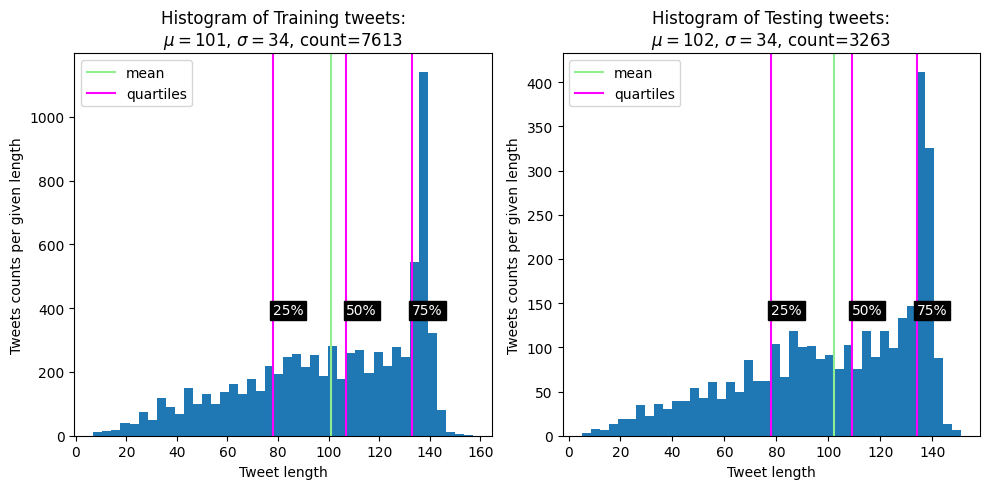

In [455]:
plot_histograms(df_train["length"], df_test["length"], df_train_len_desc, df_test_len_desc, ['Training', 'Testing'])

<p>Both data sets have a large number of tweets with character counts around 135. Lets take a look now at some of the tweets with each target value.</p>

In [456]:
display(df_train[df_train['target'] == 0].head(n=10))
display(df_train[df_train['target'] == 1].head(n=10))

,id,keyword,location,text,target,has_url,length,text_clean,length_clean
15,23,NaN,NaN,What's up man?,0,False,14,whats man,9
16,24,NaN,NaN,I love fruits,0,False,13,love fruits,11
17,25,NaN,NaN,Summer is lovely,0,False,16,summer lovely,13
18,26,NaN,NaN,My car is so fast,0,False,17,car fast,8
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0,False,28,goooooooaaaaaal,15
20,31,NaN,NaN,this is ridiculous....,0,False,22,ridiculous,10
21,32,NaN,NaN,London is cool ;),0,False,17,london cool,12
22,33,NaN,NaN,Love skiing,0,False,11,love skiing,11
23,34,NaN,NaN,What a wonderful day!,0,False,21,wonderful day,13
24,36,NaN,NaN,LOOOOOOL,0,False,8,looooool,8


,id,keyword,location,text,target,has_url,length,text_clean,length_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,False,69,deeds reason earthquake may allah forgive us,44
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,False,38,forest fire near la ronge sask canada,37
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,False,133,residents asked shelter place notified officer...,88
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,False,65,13000 people receive wildfires evacuation orde...,59
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,False,88,got sent photo ruby alaska smoke wildfires pou...,55
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,False,110,rockyfire update california hwy 20 closed dire...,90
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,False,95,flood disaster heavy rain causes flash floodin...,86
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,False,59,im top hill see fire woods,26
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,False,79,theres emergency evacuation happening building...,60
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,False,52,im afraid tornado coming area,29


<p>It appears from the first few examples of tweets for each target value, the tweets about disasters are generally longer than tweets about other topics. Lets look at a few histograms of the split.</p>

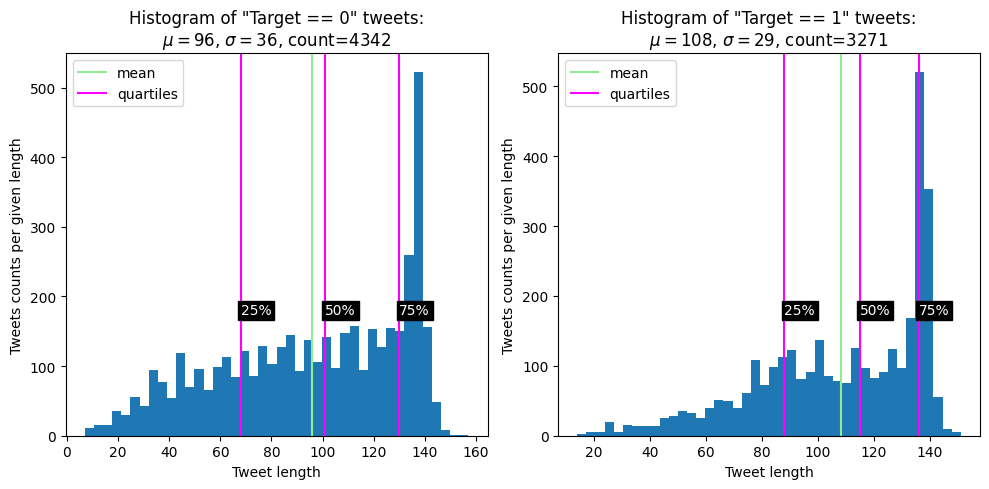

In [457]:
df_train_0_len_desc = df_train[df_train['target'] == 0]["length"].describe()
df_train_1_len_desc = df_train[df_train['target'] == 1]["length"].describe()
plot_histograms(
    df_train[df_train['target'] == 0]["length"], 
    df_train[df_train['target'] == 1]["length"], 
    df_train_0_len_desc, 
    df_train_1_len_desc, 
    ['"Target == 0"', '"Target == 1"'],
)

<p>So same overall distribution of lengths for each target value, though tweets with target == 1 (tweet is about a disaster) have an longer average length and smaller standard deviation.</p>


<p>You can see in the above prints that there are many additional characters in tweets that are specific to social media and twitter specifically, such as the @ and # symbols. Lets remove all non-english characters and urls. After the text cleaning, lets take one last look at the training data set, split into target = 0 and target = 1.</p>

In [125]:
def remove_stopword(text):
    remove_stopword = " ".join([word for word in text.split() if word.lower() not in stopwords.words('english')])

    return remove_stopword

df_train["text_clean"] = df_train["text"].apply(remove_stopword)
df_test["text_clean"] = df_test["text"].apply(remove_stopword) 

def remove_urls(text, replacement_text=""):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text_without_urls = url_pattern.sub(replacement_text, text)
 
    return text_without_urls

def clean_text(x):
    return re.sub(r"\s+", " ", remove_urls(x).translate(str.maketrans('', '', string.punctuation))).lower()

df_train["text_clean"] = df_train["text_clean"].apply(lambda x : clean_text(x)) 
df_test["text_clean"] = df_test["text_clean"].apply(lambda x : clean_text(x)) 

df_train["length_clean"] = df_train["text_clean"].apply(lambda x : len(x))
df_test["length_clean"] = df_test["text_clean"].apply(lambda x : len(x))

#display(df_train["text_clean"].head())
#display(df_test["text_clean"].head())


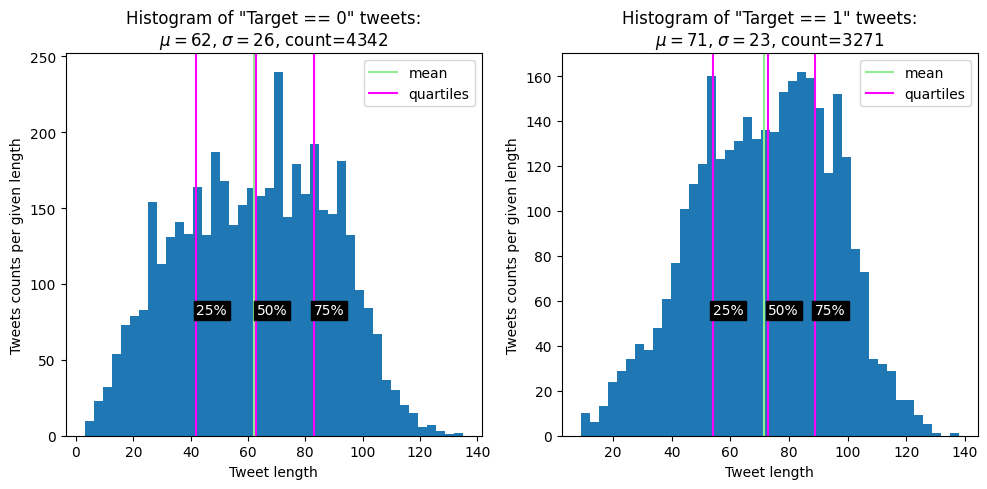

In [458]:
df_train_0_len_desc = df_train[df_train['target'] == 0]["length_clean"].describe()
df_train_1_len_desc = df_train[df_train['target'] == 1]["length_clean"].describe()
plot_histograms(
    df_train[df_train['target'] == 0]["length_clean"], 
    df_train[df_train['target'] == 1]["length_clean"], 
    df_train_0_len_desc, 
    df_train_1_len_desc, 
    ['"Target == 0"', '"Target == 1"'],
)

<p>Very drastic change in length distributions for each target value set</p>

<h2>Model Architecture</h2>

<h3>Data inputs for model fitting</h3>
<p>Lets set up the data for use in the model fittings. I'll use the Word2Vec approach and utilize the keras tokenizer() function to convert the tweets to a matrix of integers. Word2Vec works very well in this context because </p>

In [183]:
X = df_train["text_clean"]
y = df_train["target"]

max_features=5000
mode_str= 'binary'
tokenizer=keras.preprocessing.text.Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(df_train['text_clean'].values)
#X = tokenizer.texts_to_matrix(df_train['text_clean'].values, mode=mode_str)
X = tokenizer.texts_to_sequences(df_train['text_clean'].values)
X = keras.utils.pad_sequences(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


<p>Below is a test of the tokenizer and bow method. The dictionary relating a column index to a specific word is retrived from the tokenizer and used to verify a given row of the formatted training data can be reconstructed (roughly) to match the original cleaned tweet.</p>

In [187]:
test_row = 2
print(X_train.shape)
print('test:\n    ', tokenizer.sequences_to_texts([X[test_row]]))
print('original cleaned tweet:\n    ', df_train.loc[test_row,'text_clean'])

(6090, 21)
test:
     ['residents asked shelter place officers evacuation shelter place orders expected']
original cleaned tweet:
     residents asked shelter place notified officers evacuation shelter place orders expected


<p>Looks good.</p>

<h3>Hyperparameter tuning</h3>
<p>Every model architecture will have the LSTM, Bi-Dir LSTM, and GRU layer units, Dropout layer dropout rates, and learning rates tuned such that the combination of parameters that produces the model with the highest recall score will be selected as best. The list below shows the values tested:</p>
<ul><li>LSTM, Bi-Dir LSTM, and GRU layer units: [16,32,64]</li><li>Dropout layer dropout rates: [0.25, 0.5, 0.75]</li><li>Learning rates: [0.001, 0.0001, 0.00001]</li></ul>

<h3>Model architectures</h3>

<h4>Long-Short Term Memory (LSTM) architecture</h4>
<p>This will be a single layer LSTM model. To help address overfitting, dropout layers are added directly before and after. The metric to maximize in training is recall. The reasoning to use recall is that since these tweets are being judged as being about a disaster or not, you want a model that will get as many true positives and as little false negatives as possible. It is best if the models can accuratly label all the true disaster tweets, even if it mislabels some non-disaster tweets since this model could be used to send out first responders</p>

In [410]:
def lstm_model(hp):
    
    #lstm_out = 32
    hp_ltsm_units = hp.Choice("units", [16,32,64])
    hp_dropout_frac = hp.Choice("dropout_rate", [0.25, 0.5, 0.75])

    embed_dim = 32

    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(max_features, embed_dim, input_length = X.shape[1]))
    model.add(keras.layers.Dropout(hp_dropout_frac))
    model.add(keras.layers.LSTM(hp_ltsm_units))
    model.add(keras.layers.Dropout(hp_dropout_frac))
    model.add(keras.layers.Dense(1,activation='sigmoid'))

    hp_lr = hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5])

    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
        metrics= [keras.metrics.Recall()]  
    )
    
    return model

<h4>Bi-Directional LSTM architecture</h4>
<p>This will be a single layer Bi-Directional LSTM model. To help address overfitting, dropout layers are added directly before and after. An flatten layer is added after the Bi-dir LSTM to format the outputs for the Dense layer to recieve them. The metric to maximize in training is recall</p>

In [441]:
def bi_dir_lstm_model(hp):
    
    hp_ltsm_units = hp.Choice("units", [16,32,64])
    hp_dropout_frac = hp.Choice("dropout_rate", [0.25, 0.5, 0.75])

    embed_dim = 32

    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(max_features, embed_dim, input_length = X.shape[1]))
    model.add(keras.layers.Dropout(hp_dropout_frac))
    model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(hp_ltsm_units, return_sequences=True)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(hp_dropout_frac))
    model.add(keras.layers.Dense(1,activation='sigmoid'))

    hp_lr = hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5])

    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
        metrics= [keras.metrics.Recall()]  
    )
    
    return model

<h4>GRU architecture</h4>
<p>This will be a single layer GRU model. To help address overfitting, dropout layers are added directly before and after. The metric to maximize in training is recall</p>

In [427]:
def gru_model(hp):
    
    hp_gru_units = hp.Choice("units", [16,32,64])
    hp_dropout_frac = hp.Choice("dropout_rate", [0.25, 0.5, 0.75])
    embed_dim = 32

    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(max_features, embed_dim, input_length = X.shape[1]))
    model.add(keras.layers.Dropout(hp_dropout_frac))
    model.add(tf.keras.layers.GRU(hp_gru_units))
    model.add(keras.layers.Dropout(hp_dropout_frac))
    model.add(keras.layers.Dense(1,activation='sigmoid'))

    hp_lr = hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5])

    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
        metrics= [keras.metrics.Recall()]  
    )
    
    return model

<h3>Tuners to find optimal hyperparametrs</h3>

In [407]:
tuner_files_dir = 'C:/Users/kgrit/OneDrive/Documents/UC boulder Data science masters/Intro to deep learning/week 4/assignment final'
t_objective = keras_tuner.Objective("recall", direction="max")
t_max_trials = 50
t_overwrite = True
t_executions_per_trial = 1

In [411]:
tuner_lstm = RandomSearch(
    lstm_model,
    objective=t_objective,
    max_trials=t_max_trials,
    overwrite=t_overwrite,
    executions_per_trial=t_executions_per_trial,
    directory=tuner_files_dir,
    project_name='lstm_model')

In [442]:

tuner_bi_dir_lstm = RandomSearch(
    bi_dir_lstm_model,
    objective=t_objective,
    max_trials=t_max_trials,
    overwrite=t_overwrite,
    executions_per_trial=t_executions_per_trial,
    directory=tuner_files_dir,
    project_name='bi_dir_lstm_model')

In [429]:
tuner_gru = RandomSearch(
    gru_model,
    objective=t_objective,
    max_trials=t_max_trials,
    overwrite=t_overwrite,
    executions_per_trial=t_executions_per_trial,
    directory=tuner_files_dir,
    project_name='gru_model')

<h2>Results and Analysis</h2>

<p>Now lets run the tuners and find the best set of hyperparameters for each model architecture.</p>

In [412]:
tuner_lstm.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
models_lstm = tuner_lstm.get_best_models(num_models=2)
best_model_lstm = models_lstm[0]

Trial 27 Complete [00h 00m 19s]
recall: 0.8779557347297668

Best recall So Far: 0.8802440762519836
Total elapsed time: 00h 07m 51s


In [413]:
best_hps_lstm = tuner_lstm.get_best_hyperparameters(1)[0]
print(best_hps_lstm.values)
best_model_lstm.summary()

{'units': 16, 'dropout_rate': 0.25, 'learning_rate': 0.001}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 32)            160000    
                                                                 
 dropout (Dropout)           (None, 21, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 163,153
Trainable params: 163,153
Non-trainable params: 0
________________________________________________________

In [443]:
tuner_bi_dir_lstm.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
models_bi_dir_lstm = tuner_bi_dir_lstm.get_best_models(num_models=2)
best_model_bi_dir_lstm = models_bi_dir_lstm[0]

Trial 26 Complete [00h 00m 21s]
recall: 0.8935926556587219

Best recall So Far: 0.8985507488250732
Total elapsed time: 00h 08m 58s


In [444]:
best_hps_bi_dir_lstm = tuner_bi_dir_lstm.get_best_hyperparameters(1)[0]
print(best_hps_bi_dir_lstm.values)
best_model_bi_dir_lstm.summary()

{'units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.001}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 32)            160000    
                                                                 
 dropout (Dropout)           (None, 21, 32)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 21, 64)           16640     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 1344)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1344)              0         
                                                                 
 dense (Dense)               (None, 1)                 1345   

In [431]:
tuner_gru.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
models_gru = tuner_gru.get_best_models(num_models=2)
best_model_gru = models_gru[0]

Trial 27 Complete [00h 00m 17s]
recall: 0.7711670398712158

Best recall So Far: 0.8989320993423462
Total elapsed time: 00h 07m 30s


In [432]:
best_hps_gru = tuner_gru.get_best_hyperparameters(1)[0]
print(best_hps_gru.values)
best_model_gru.summary()

{'units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.001}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 32)            160000    
                                                                 
 dropout (Dropout)           (None, 21, 32)            0         
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 166,369
Trainable params: 166,369
Non-trainable params: 0
________________________________________________________

<h3>Best model fitting for LTSM, Bi-LSTM, and GRU models</h3>

<p>Here the haperparameters from the bost models found earlier will be used to construct and train new models for the hyperparameters given architecture. To guard against overfitting, the models will have a callback that will stop fitting when the validation loss increases in value continuously over two epochs. If that is detected and the fitting is stopped, the weights of the best performing (lowest loss) epoch will be restored.</p>

In [215]:
batch_size = 32
epochs = 10

In [414]:
callbacks_lstm = [
    keras.callbacks.ModelCheckpoint(filepath="final_lstm_model\model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
]

final_lstm_model = lstm_model(best_hps_lstm)

final_lstm_model_history = final_lstm_model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks_lstm,
)

Epoch 1/10


191/191 [==============================] - 5s 20ms/step - loss: 0.6133 - recall_1: 0.2689 - val_loss: 0.4814 - val_recall_1: 0.6610
Epoch 2/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3944 - recall_1: 0.7639 - val_loss: 0.4453 - val_recall_1: 0.7011
Epoch 3/10
191/191 [==============================] - 3s 18ms/step - loss: 0.3116 - recall_1: 0.8173 - val_loss: 0.4775 - val_recall_1: 0.7257
Epoch 4/10
191/191 [==============================] - 3s 18ms/step - loss: 0.2590 - recall_1: 0.8574 - val_loss: 0.5496 - val_recall_1: 0.7304


In [461]:
final_lstm_model.save("final_lstm_model.keras")

In [255]:
callbacks_bi_dir_lstm = [
    keras.callbacks.ModelCheckpoint(filepath="final_bi_dir_lstm_model\model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
]

final_bi_dir_lstm_model = bi_dir_lstm_model(best_hps_bi_dir_lstm)

final_bi_dir_lstm_model_history = final_bi_dir_lstm_model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks_bi_dir_lstm,
)

Epoch 1/10


191/191 [==============================] - 3s 10ms/step - loss: 0.5857 - accuracy: 0.6855 - val_loss: 0.4833 - val_accuracy: 0.7953
Epoch 2/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3840 - accuracy: 0.8448 - val_loss: 0.4525 - val_accuracy: 0.7968
Epoch 3/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3088 - accuracy: 0.8831 - val_loss: 0.4983 - val_accuracy: 0.7892
Epoch 4/10
191/191 [==============================] - 1s 7ms/step - loss: 0.2555 - accuracy: 0.9072 - val_loss: 0.5087 - val_accuracy: 0.7840


In [460]:
final_bi_dir_lstm_model.save("final_bi_dir_lstm_model.keras")

In [462]:
callbacks_gru = [
    keras.callbacks.ModelCheckpoint(filepath="final_gru_model\model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
]

final_gru_model = gru_model(best_hps_gru)

final_gru_model_history = final_gru_model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks_lstm,
)

Epoch 1/10
 98/191 [==============>...............] - ETA: 0s - loss: 0.6631 - recall_1: 0.1163

191/191 [==============================] - 2s 5ms/step - loss: 0.5867 - recall_1: 0.3642 - val_loss: 0.4547 - val_recall_1: 0.6333
Epoch 2/10
191/191 [==============================] - 1s 4ms/step - loss: 0.3663 - recall_1: 0.7674 - val_loss: 0.4652 - val_recall_1: 0.6965
Epoch 3/10
191/191 [==============================] - 1s 4ms/step - loss: 0.2862 - recall_1: 0.8288 - val_loss: 0.5195 - val_recall_1: 0.7504


In [459]:
final_gru_model.save("final_gru_model.keras")

<h2>Results and Analysis (35 pts)</h2>

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

<h3>Hyperparameter optimization procedure summary</h3>
<p>As stated previously, the main layers unit number, the dense layer drop out rate, and the learning rates were all tunedto find the best performing models for each of the three architectures.</p>
<p>The procedure was simply:</p>
<ol><li>Generate the list of all combinations of hyperparameters to test and what metric to judge the models by using keras_tuner</li><li>Train one model per each hyperparamter set for 5 epochs</li><li>Choose the model + hyperparamter set that achieved the highest recall score</li></ol>


<h3>Final model confusion matrices and Hyperparameter recall score breakdown</h3>
<p>Below are charts that show how every hyperparamter set scored with regards to recall for all architectures. Also, there are confusion matrices that showcase how each final model did when predicting the disaster/not disaster label of tweets in the training set and validation set.</p>

In [513]:

def displayConfusionMatrix(y_true_train, y_pred_train, y_true_val, y_pred_val, model):

    fig, ax = plt.subplots(1,2, figsize=(10, 4))

    y_pred_train = pd.Series(np.round(y_pred_train).reshape(y_pred_train.shape[0]))
    y_pred_val = pd.Series(np.round(y_pred_val).reshape(y_pred_val.shape[0]))
    
    disp_1 = ConfusionMatrixDisplay.from_predictions(
        y_true_train,
        #np.argmax(y_pred, axis=1),
        y_pred_train,
        normalize='true',
        display_labels=["Not Disaster","Disaster"],
        ax=ax[0], cmap=plt.cm.Blues
    )

    disp_2 = ConfusionMatrixDisplay.from_predictions(
        y_true_val,
        #np.argmax(y_pred, axis=1),
        y_pred_val,
        normalize='true',
        display_labels=["Not Disaster","Disaster"],
        ax=ax[1], cmap=plt.cm.Greens
    )

    #tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    def calc_f1_score(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        f1_score = tp / (tp+((fn+fp)/2))
        recall_score = tp/(tp + fn)
        return [['recall', recall_score], ['F1', f1_score]]

    score_1 = calc_f1_score(y_true_train, y_pred_train)
    score_2 = calc_f1_score(y_true_val, y_pred_val)

    

    disp_1.ax_.set_title(f"{model}\nConfusion Matrix on Training Dataset\ntrain {score_1[0][0]} Score: {str(score_1[0][1].round(3))}\ntrain {score_1[1][0]} Score: {str(score_1[1][1].round(3))}")
    disp_2.ax_.set_title(f"{model}\nConfusion Matrix on Validation Dataset\nval {score_2[0][0]} Score: {str(score_2[0][1].round(3))}\ntrain {score_2[1][0]} Score: {str(score_2[1][1].round(3))}")
    
    fig.tight_layout()


In [416]:
import os.path
def make_dfs_for_alt(tuner_in):
    trial_list = ["%02d" % (i,) for i in range(28)]
    cols_to_get_hp = ['units', 'dropout_rate', 'learning_rate'] 
    cols_to_get_scores = ['loss', 'recall', 'val_loss', 'val_recall']

    data_for_plot = {col: [0 for i in range(28)] for col in cols_to_get_hp + cols_to_get_scores}
                    
    for ind, trial_num in enumerate(trial_list):
        trial_path_f = tuner_in.get_trial_dir(trial_id=trial_num) + '\\trial.json'
        if os.path.isfile(trial_path_f):
            trial_path = open(trial_path_f)
            trial_data = json.load(trial_path)

            for col in cols_to_get_hp:
                data_for_plot[col][ind] = trial_data['hyperparameters']['values'][col]
            for col in cols_to_get_scores:
                data_for_plot[col][ind] = trial_data['metrics']['metrics'][col]['observations'][0]['value'][0]

            trial_path.close()

    return pd.DataFrame(data=data_for_plot)


In [421]:

def print_alt(df_in):
    feat_1 = 'dropout_rate'
    feat_2 = 'units'
    feat_3 = 'recall'
    chart1 = alt.Chart(df_in, title=f"Training {feat_3}").mark_line().encode(
        alt.X('learning_rate').scale(zero=False, type="log"),
        #alt.X('learning_rate').scale(zero=False),
        alt.Y(feat_3).scale(zero=False, padding=1),
        alt.Color(f'{feat_2}:N').scale(zero=False),
        strokeDash=feat_1,
    )

    chart2 = alt.Chart(df_in, title="Training loss").mark_line().encode(
        alt.X('learning_rate').scale(zero=False, type="log"),
        #alt.X('learning_rate').scale(zero=False),
        alt.Y('loss').scale(zero=False, padding=1),
        alt.Color(f'{feat_2}:N').scale(zero=False),
        strokeDash=feat_1,
    )


    chart3 = alt.Chart(df_in, title=f"Validation {feat_3}").mark_line().encode(
        alt.X('learning_rate').scale(zero=False, type="log"),
        #alt.X('learning_rate').scale(zero=False),
        alt.Y(f'val_{feat_3}').scale(zero=False, padding=1),
        alt.Color(f'{feat_2}:N').scale(zero=False),
        strokeDash=feat_1,
    )

    chart4 = alt.Chart(df_in, title="Validation loss").mark_line().encode(
        alt.X('learning_rate').scale(zero=False, type="log"),
        #alt.X('learning_rate').scale(zero=False),
        alt.Y('val_loss').scale(zero=False, padding=1),
        alt.Color(f'{feat_2}:N').scale(zero=False),
        strokeDash=f'{feat_1}:N',
    )

    #alt.vconcat((chart1 | chart2), (chart3_1 | chart4)).show()
    (chart1 | chart2).show()
    (chart3 | chart4).show()
    #(chart1 | chart2 | chart3 | chart4).show()

<h3>Assessment of LSTM model</h3>


In [417]:
hp_lstm_df = make_dfs_for_alt(tuner_lstm)
hp_lstm_df = hp_lstm_df[hp_lstm_df['units'] > 0]

In [422]:
print(tuner_lstm.get_best_hyperparameters(1)[0].values)
print_alt(hp_lstm_df)

{'units': 16, 'dropout_rate': 0.25, 'learning_rate': 0.001}


alt.HConcatChart(...)

alt.HConcatChart(...)

<p>Here you can see that every potential parameter set benifited from having a larger learning rate. Most models tested experienced a drop in recall score before having a large jump in score value, except for the models that had larger numbers of LSTM/ Bi-dir LSTM/GRU layers units.</p>

In [423]:
y_pred_train_lstm = final_lstm_model.predict(X_train)
y_pred_val_lstm = final_lstm_model.predict(X_val)

 48/191 [======>.......................] - ETA: 1s

48/48 [==============================] - 0s 5ms/step


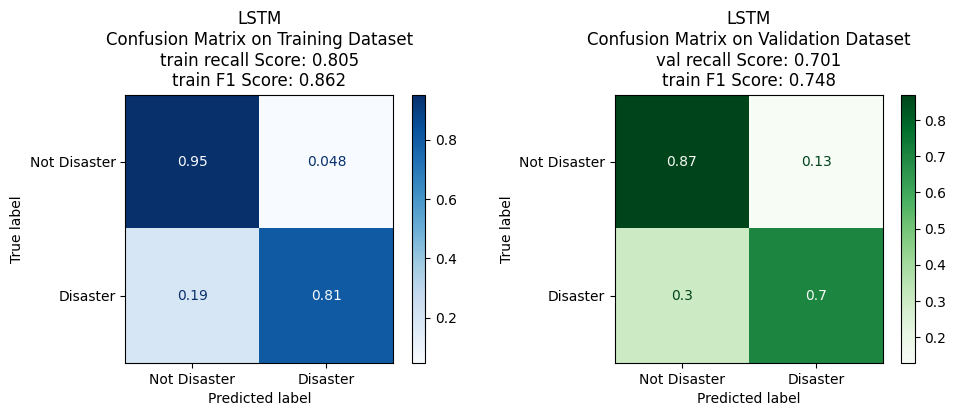

In [514]:

displayConfusionMatrix(y_train, y_pred_train_lstm, y_val, y_pred_val_lstm, 'LSTM')

<p>Here you can see that the best final model did very well accuratly labeling tweets that were NOT about disasters, but had more trouble accuratly labeling tweets that truely were about a disaster, with the validation predictions doing worse than the training predictions.</p>

<h3>Assessment of Bi-directional LSTM model</h3>

In [445]:
hp_bd_lstm_df = make_dfs_for_alt(tuner_bi_dir_lstm)
hp_bd_lstm_df = hp_bd_lstm_df[hp_bd_lstm_df['units'] > 0]

In [446]:
print_alt(hp_bd_lstm_df)
print(tuner_bi_dir_lstm.get_best_hyperparameters(1)[0].values)

alt.HConcatChart(...)

alt.HConcatChart(...)

{'units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.001}


<p>Here you can see that every potential parameter set benifited from having a larger learning rate, as for the SLTM models. About half of the models tested experienced a drop in recall score before having a large jump in score value, but models that had the lowest dropout rate of 0.25 did the best overall and had the greatest improvement in recall score as learning rate decreased.</p>

In [447]:
y_pred_train_bd_lstm = final_bi_dir_lstm_model.predict(X_train)
y_pred_val_bd_lstm = final_bi_dir_lstm_model.predict(X_val)

 50/191 [======>.......................] - ETA: 2s

48/48 [==============================] - 1s 10ms/step


In [451]:
y_pred_train_bd_lstm = np.array([np.round(np.mean(i)) for i in y_pred_train_bd_lstm])
y_pred_val_bd_lstm = np.array([np.round(np.mean(i)) for i in y_pred_val_bd_lstm])

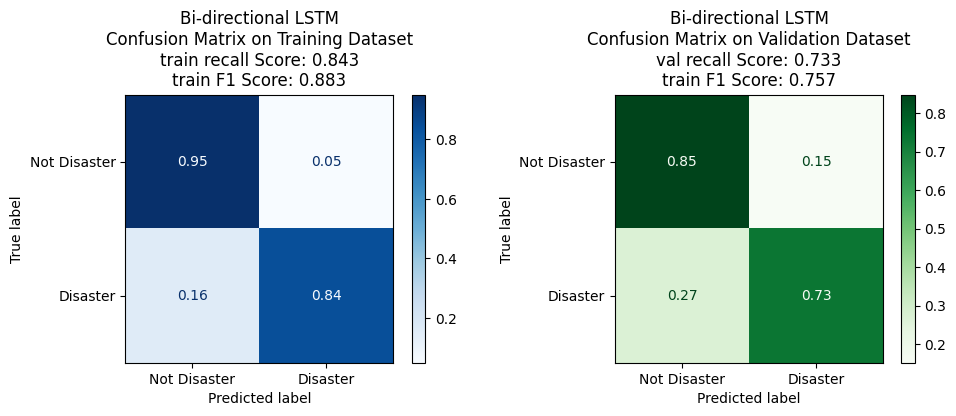

In [515]:

displayConfusionMatrix(y_train, y_pred_train_bd_lstm, y_val, y_pred_val_bd_lstm, 'Bi-directional LSTM')

<p>As with the final best LSTM model, the best Bi-Directional LSTM final model did very well accuratly labeling tweets that were NOT about disasters, but had more trouble accuratly labeling tweets that truely were about a disaster. The validation predictions from this model were slighly better than for the straight LSTM model.</p>

<h3>Assessment of GRU model</h3>

In [434]:
hp_gru_df = make_dfs_for_alt(tuner_gru)
hp_gru_df = hp_gru_df[hp_gru_df['units'] > 0]

In [435]:
print(tuner_gru.get_best_hyperparameters(1)[0].values)
print_alt(hp_gru_df)

{'units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.001}


alt.HConcatChart(...)

alt.HConcatChart(...)

<p>Here you can see similar behave to the other models hyperparameter sets.</p>

In [436]:
y_pred_train_gru = final_gru_model.predict(X_train)
y_pred_val_gru = final_gru_model.predict(X_val)

 63/191 [========>.....................] - ETA: 1s

48/48 [==============================] - 0s 4ms/step


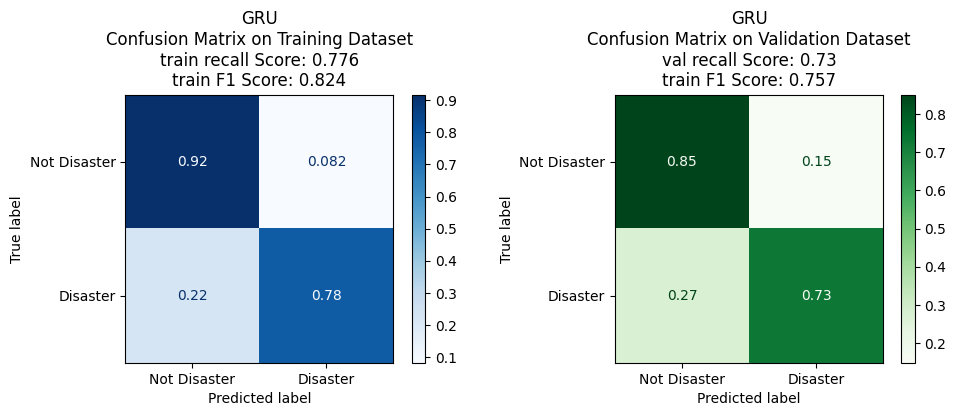

In [516]:
displayConfusionMatrix(y_train, y_pred_train_gru, y_val, y_pred_val_gru, 'GRU')

<p>As with the last two best models, the best GRU final model did very well accuratly labeling tweets that were NOT about disasters, but had more trouble accuratly labeling tweets that truely were about a disaster. The validation predictions from this model were on par wth those from the Bi-directional LSTM model.</p>

<h3>Kagge prediction and score</h3>

<p>The test data set will now be fed into the pretrained tokenizer, formated for the Bi-directional LSTM model (it had the best recall score), verified it can be reconstructed into the original cleaned tweets, and passed into the model for predictiong the correct test tweet label.</p>

In [464]:
final_test = tokenizer.texts_to_sequences(df_test['text_clean'].values)
final_test = keras.utils.pad_sequences(final_test)

In [520]:

for i in range(3):
    print(f'row {i}')
    print('reconstructed tokenized tweet:\n    ', tokenizer.sequences_to_texts([final_test[i]]))
    print('original cleaned tweet:\n    ', df_test.loc[i,'text_clean'], end='\n\n')

row 0
reconstructed tokenized tweet:
     ['happened terrible car crash']
original cleaned tweet:
     happened terrible car crash

row 1
reconstructed tokenized tweet:
     ['heard earthquake different cities stay safe everyone']
original cleaned tweet:
     heard earthquake different cities stay safe everyone

row 2
reconstructed tokenized tweet:
     ['forest fire spot pond fleeing across street cannot save']
original cleaned tweet:
     forest fire spot pond geese fleeing across street cannot save



In [487]:
y_pred_test_bd_lstm = final_bi_dir_lstm_model.predict(final_test)

102/102 [==============================] - 1s 13ms/step


In [503]:
y_pred_test_bd_lstm_to_sub = [int(np.round(np.mean(i))) for i in y_pred_test_bd_lstm]

In [508]:
for i in range(9):
    print('pred label: ', y_pred_test_bd_lstm_to_sub[i], 'text: ', df_test.loc[i, 'text'], end='\n\n')

pred label:  1 text:  Just happened a terrible car crash

pred label:  1 text:  Heard about #earthquake is different cities, stay safe everyone.

pred label:  1 text:  there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all

pred label:  1 text:  Apocalypse lighting. #Spokane #wildfires

pred label:  1 text:  Typhoon Soudelor kills 28 in China and Taiwan

pred label:  1 text:  We're shaking...It's an earthquake

pred label:  0 text:  They'd probably still show more life than Arsenal did yesterday, eh? EH?

pred label:  0 text:  Hey! How are you?

pred label:  0 text:  What a nice hat?



In [509]:
sample_submission = pd.read_csv("C:/Users/kgrit/OneDrive/Documents/UC boulder Data science masters/Intro to deep learning/week 4/assignment rough draft/data/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [510]:
sample_submission["target"] = y_pred_test_bd_lstm_to_sub

In [512]:
sample_submission.to_csv("kaggle_submission_final.csv", index=False)

![alt text](<kaggle_submission_screenshot.png>)

<h2>Conclusion</h2>

<h3>General takeways</h3>
<p>From the three model architectures, the optimized bi-directional LSTM model did the best, though not by much. Interestingly, the model did slightly better predicting the test tweet labels as it did on the validation data set labels, with regards to F1. Frankly I am amazed that just a single layer of any of the three main layer types tested here was able to do so well. That could speak to the strengths of these kinds of layers, the method of word tokenization, or most likely both. One big takeway however is that reducing the size of the input has a drastic affect on model training/fitting time, as is likely obvious. A clever choice of word tokenization can greatly reduce training time and if it is information dense enough, still lead to strong model performance.<p>
<h3>Model performace helpers and detractors</h3>
<p>On previous iterations of this problem challenge, I set the models to use accuracy score in the model compiler. I found this did not help because even though the accuracy scores and F1 scores improved, the models did poorly when it came to the most improtant tests, accurately labeling the true disaster tweets correctly. By changing the scoring metric to recall, I was able to modestly improve the model performances.</p>
<p>Another thing that had a positive impact on model performance was the Word2Vec word embedding process. After testing out a few others such as TF-IDF and Bag-of-words, I found that Word2Vec operations produced a much smaller input for the models and allowed them to be trained very fast. orders of magnitude faster than with the other word embedding stategizes as I had implimented them.</p>
<h3>Possible future improvements</h3>
<p>In the fiuture, making the models more complex will liekyl improve the model performance. In this case, each model only had one layer of LSTM, Bi-direcitnoal LSTM, and GRU layer, with the additional dropout layers surrounding them. With additional layers, the models very liekyl will perform much better.</p>

<h2>Acknowledgements</h2>
<p>1. SandhyaKrishnan02 (2022) NLP with Disaster Tweets using LSTM, Kaggle. Kaggle. Available at: https://www.kaggle.com/code/sandhyakrishnan02/nlp-with-disaster-tweets-using-lstm.</p>
<p>2. Koo Ping Shung (2018) Accuracy, Precision, Recall or F1?, Towards Data Science. Available at: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9.</p>
<p>3. Masatoshi Kato (2022) Effective EDA & BERT in NLP (BERT Baseline), Kaggle. Kaggle. Available at: https://www.kaggle.com/code/masatoshikato/effective-eda-bert-in-nlp-bert-baseline.</p>
<p>4. Alexia Audevart (2023) KerasNLP starter notebook Disaster Tweets, Kaggle. Kaggle. Available at: https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets.</p>
<p>5. Akash Deep (2020) Understanding NLP Keras Tokenizer Class Arguments with example. Medium. Available at: https://medium.com/analytics-vidhya/understanding-nlp-keras-tokenizer-class-arguments-with-example-551c100f0cbd.</p>